In [1]:
import importlib
import os
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import dill
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from scipy.spatial import KDTree
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats._continuous_distns import genpareto

import grapher

# Custom
import mstmeclass as mc
from mstmeclass import MSTME, SIMSET, STM, Area

In [2]:
pos_color = plt.rcParams["axes.prop_cycle"].by_key()["color"]


# Load data

In [3]:
region = "guadeloupe"
N_subsample = 100
rf = "h-west"
RECALC = False
thr_pct_mar = 0.6
thr_pct_com = 0.65

In [4]:
path_mstme = Path(
    f"./output/{region}/{rf}/GP{round(thr_pct_mar*100)}%_CM{round(thr_pct_com*100)}%_{N_subsample}subsamples/mstme_condition.dill"
)
with open(path_mstme, "rb") as f:
    mstme_condition: MSTME = dill.load(f)
    tree = KDTree(mstme_condition.latlon)
    grid_res = 10
    lat_list = np.linspace(mstme_condition.area.min_lat, mstme_condition.area.max_lat, grid_res)
    lon_list = np.linspace(mstme_condition.area.min_lon, mstme_condition.area.max_lon, grid_res)
    dist_list, pos_list = tree.query(
        [[[lat, lon] for lat in lat_list] for lon in lon_list]
    )
    pos_list = pos_list.flatten()
    pos_list = np.unique(pos_list)
    # if not hasattr(mstme_condition, "pval"):
    #     mstme_condition.calc_kendall_tau()
    # ratio_kt_fail = (
    #     np.count_nonzero(mstme_condition.pval[:, :, pos_list] < 0.05, axis=2) / pos_list.size
    # )

In [5]:
import os
os.environ["OPENBLAS_MAIN_FREE"] = "1"
# os.environ["OPENBLAS_MAIN_FREE"]

In [6]:
rng = np.random.default_rng()

In [7]:
importlib.reload(mc)

<module 'mstmeclass' from 'J:\\mstme\\src\\mstmeclass.py'>

In [8]:
N_year_pool = 200
N_subsample = 1000
path_mstme_ss_dill = path_mstme.parent.joinpath(
    f"mstme_ss_{N_subsample}_pool_{N_year_pool}.dill"
)
if path_mstme_ss_dill.exists():
    with open(path_mstme_ss_dill, "rb") as f:
        tm_MSTME_ss, stm_MSTME_ss = dill.load(f)
    if tm_MSTME_ss.shape[0] != N_subsample:
        warnings.warn(
            f"Sample count of {tm_MSTME_ss.shape[0]} for mstme_ss_dill does not match the input:{N_subsample} (GP{round(thr_pct_mar*100)}%_CM{round(thr_pct_com*100)}%)"
        )
else:
    try:
        tm_MSTME_ss, stm_MSTME_ss = mc.subsample_MSTME(
            mstme_condition,
            N_subsample,
            N_year_pool,
            pos_list=pos_list,
        )
        # with path_mstme_ss_dill.open("wb") as f:
        #     dill.dump((tm_MSTME_ss, stm_MSTME_ss), f)
    except mc.SubsampleException as e:
        print(e)

In [9]:
# with path_mstme_ss_dill.open("wb") as f:
#     dill.dump((tm_MSTME_ss, stm_MSTME_ss), f)

In [10]:
dir_out = Path(f"./output/{region}/summary/NO_MAX_THR/{rf}")
if not dir_out.exists():
    dir_out.mkdir(parents=True, exist_ok=True)

# Marginal results

## STM


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

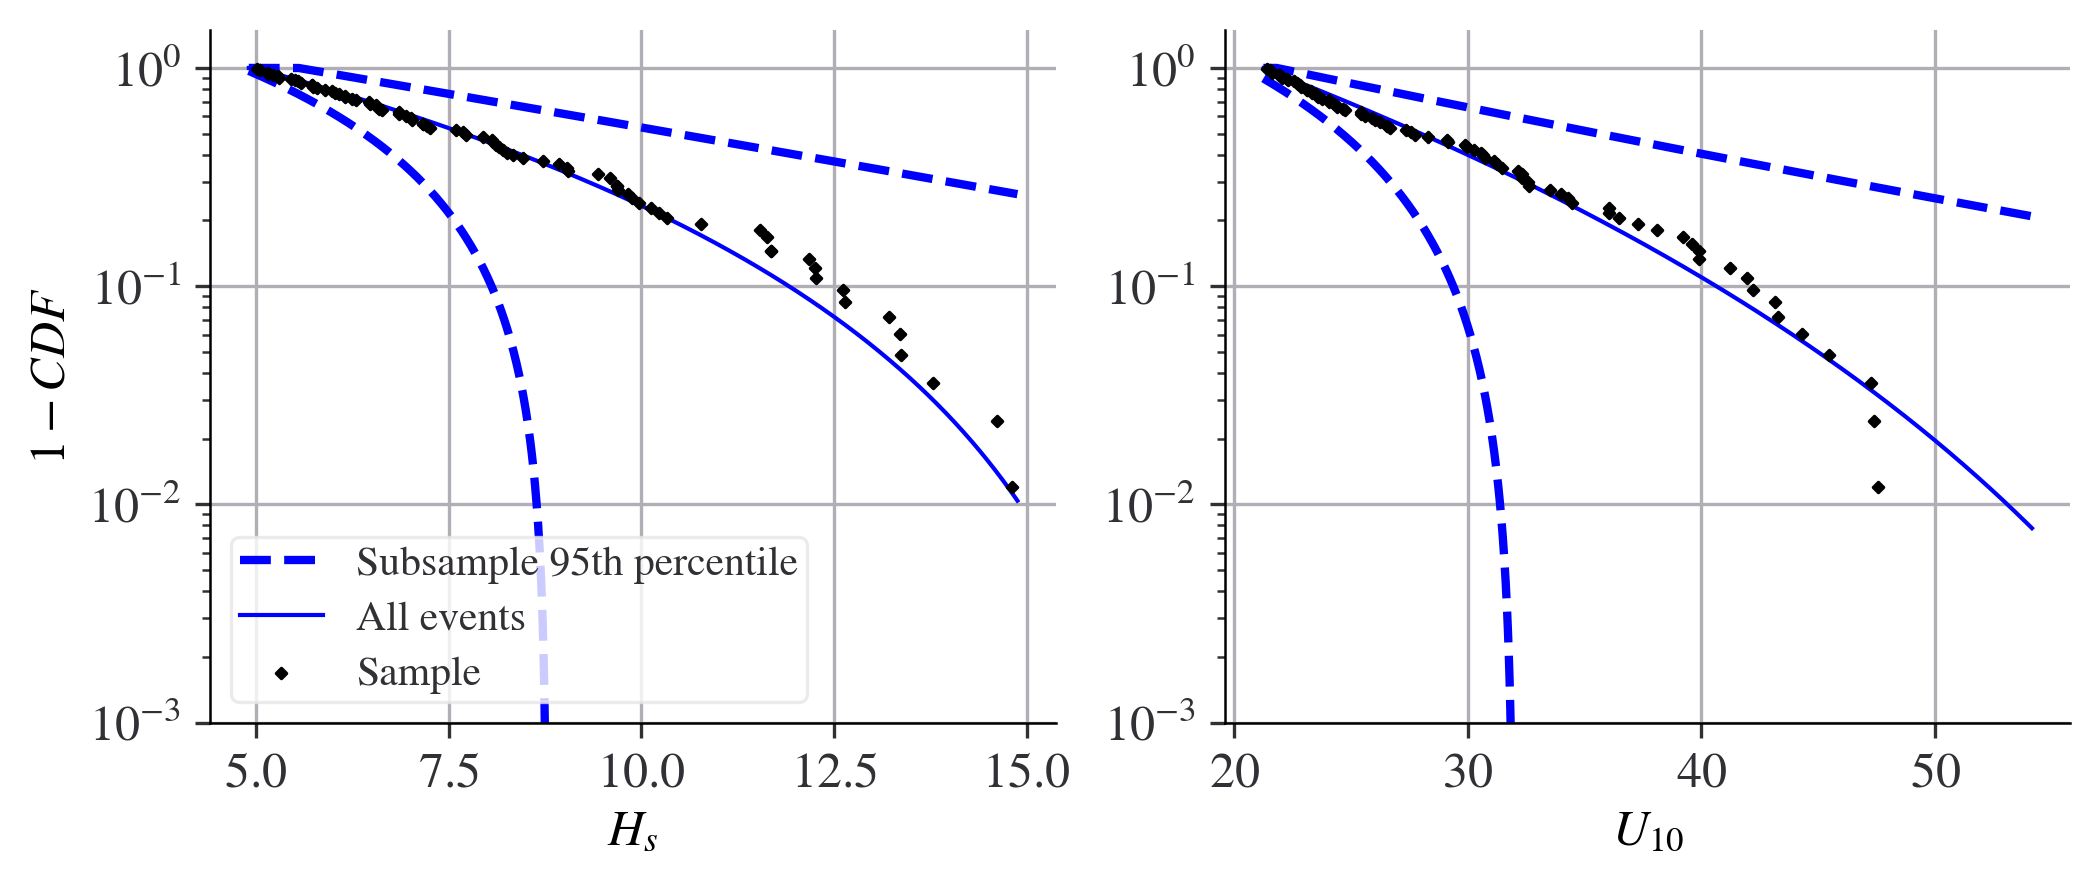

In [11]:
# make event masks for subsampling shared by mstme and pwe
num_ss = 1000
_num_events_ss = round(N_year_pool * mstme_condition.occur_freq)
_mask_ss = mc._get_ss_pool(mstme_condition, num_ss, _num_events_ss)
genpar_params_ss = []
for ssi in range(num_ss):
    print(ssi)
    # _mask = np.logical_and(_mask_ss[ssi],mstme_condition.is_e_mar[vi])
    _mask = _mask_ss[ssi]
    _, genpar_params = mc._genpar_estimation(mstme_condition.get_root().stm[:,_mask],mstme_condition.thr_mar)
    genpar_params_ss.append(genpar_params)
genpar_params_ss = np.array(genpar_params_ss)
genpar_params_u95 = np.percentile(np.mean(genpar_params_ss,axis=2),97.5,axis=0)
genpar_params_l95 = np.percentile(np.mean(genpar_params_ss,axis=2),02.5,axis=0)

fig, ax = plt.subplots(1, 2, figsize=(4 * 2, 3), facecolor="white")
for S in STM:
    vi = S.idx()
    stm = mstme_condition.stm[vi, mstme_condition.is_e_mar[vi]]
    x = np.linspace(mstme_condition.thr_mar[vi], stm.max(), 1000)
    ax[vi].plot(
        x,
        1
        - genpareto(
            c=genpar_params_u95[vi][0],
            loc=genpar_params_u95[vi][1],
            scale=genpar_params_u95[vi][2],
        ).cdf(x),
        lw=2,
        linestyle="--",
        c="blue",
        label="Subsample 95th percentile",
    )
    ax[vi].plot(
        x,
        1
        - genpareto(
            c=genpar_params_l95[vi][0],
            loc=genpar_params_l95[vi][1],
            scale=genpar_params_l95[vi][2],
        ).cdf(x),
        lw=2,
        linestyle="--",
        c="blue",
    )
    ax[vi].plot(x, 1 - mstme_condition.gp[vi].cdf(x), lw=1, c="blue", label="All events")
    ecdf = ECDF(stm)
    ax[vi].scatter(
        stm, 1 - ecdf(stm), c="k", marker="D", s=3, zorder=10, label="Sample"
    )
    ax[vi].grid(which="major")
    # ax[vi].grid(which='minor')
    ax[vi].set_xlabel(f"{S.name()}")
    ax[vi].set_yscale("log")
    ax[vi].set_ylim(bottom=1e-3, top=1.5)
ax[0].set_ylabel("$1-CDF$")
ax[0].legend()

plt.savefig(dir_out/f"GPD_subsample.png",bbox_inches='tight')
plt.savefig(dir_out/f"GPD_subsample.pdf",bbox_inches='tight')


In [ ]:

fig, ax = plt.subplots(1,2,figsize=(4*2,3),facecolor='white')
for S in STM:
  vi = S.idx()
  stm = mstme_condition.stm[vi, mstme_condition.is_e_mar[vi]]
  x = np.linspace(mstme_condition.thr_mar[vi],stm.max(),1000)
  ax[vi].plot(x, 1-mstme_condition.gp[vi].cdf(x),lw=5,label='GPD')
  ecdf = ECDF(stm)
  ax[vi].scatter(stm, 1-ecdf(stm), c='k',marker='D',s=3,zorder=10,label='Sample')
  ax[vi].set_yscale('log')
  ax[vi].grid(which='major')
  ax[vi].grid(which='minor')
  ax[vi].set_xlabel(f'{S.name()}')
ax[0].legend()
plt.hist(stm_MSTME_ss[0,0,:])
plt.hist(mstme_condition.stm[0,mstme_condition.is_e[0]])

## TM

In [10]:

return_period = 500

# Sample count over threshold
num_events_sample = tm_MSTME_ss.shape[2]
exceedance_prob_com = 1 - mstme_condition.thr_pct_com
exceedance_prob = 1 / (return_period * mstme_condition.occur_freq * exceedance_prob_com)
count_sample = round(
    num_events_sample
    / (return_period * mstme_condition.occur_freq * exceedance_prob_com)
)
num_events_original = mstme_condition.num_events
count_original = round(
    num_events_original / (return_period * mstme_condition.occur_freq)  
)
exceedance_prob_original = 1 / (return_period * mstme_condition.occur_freq)


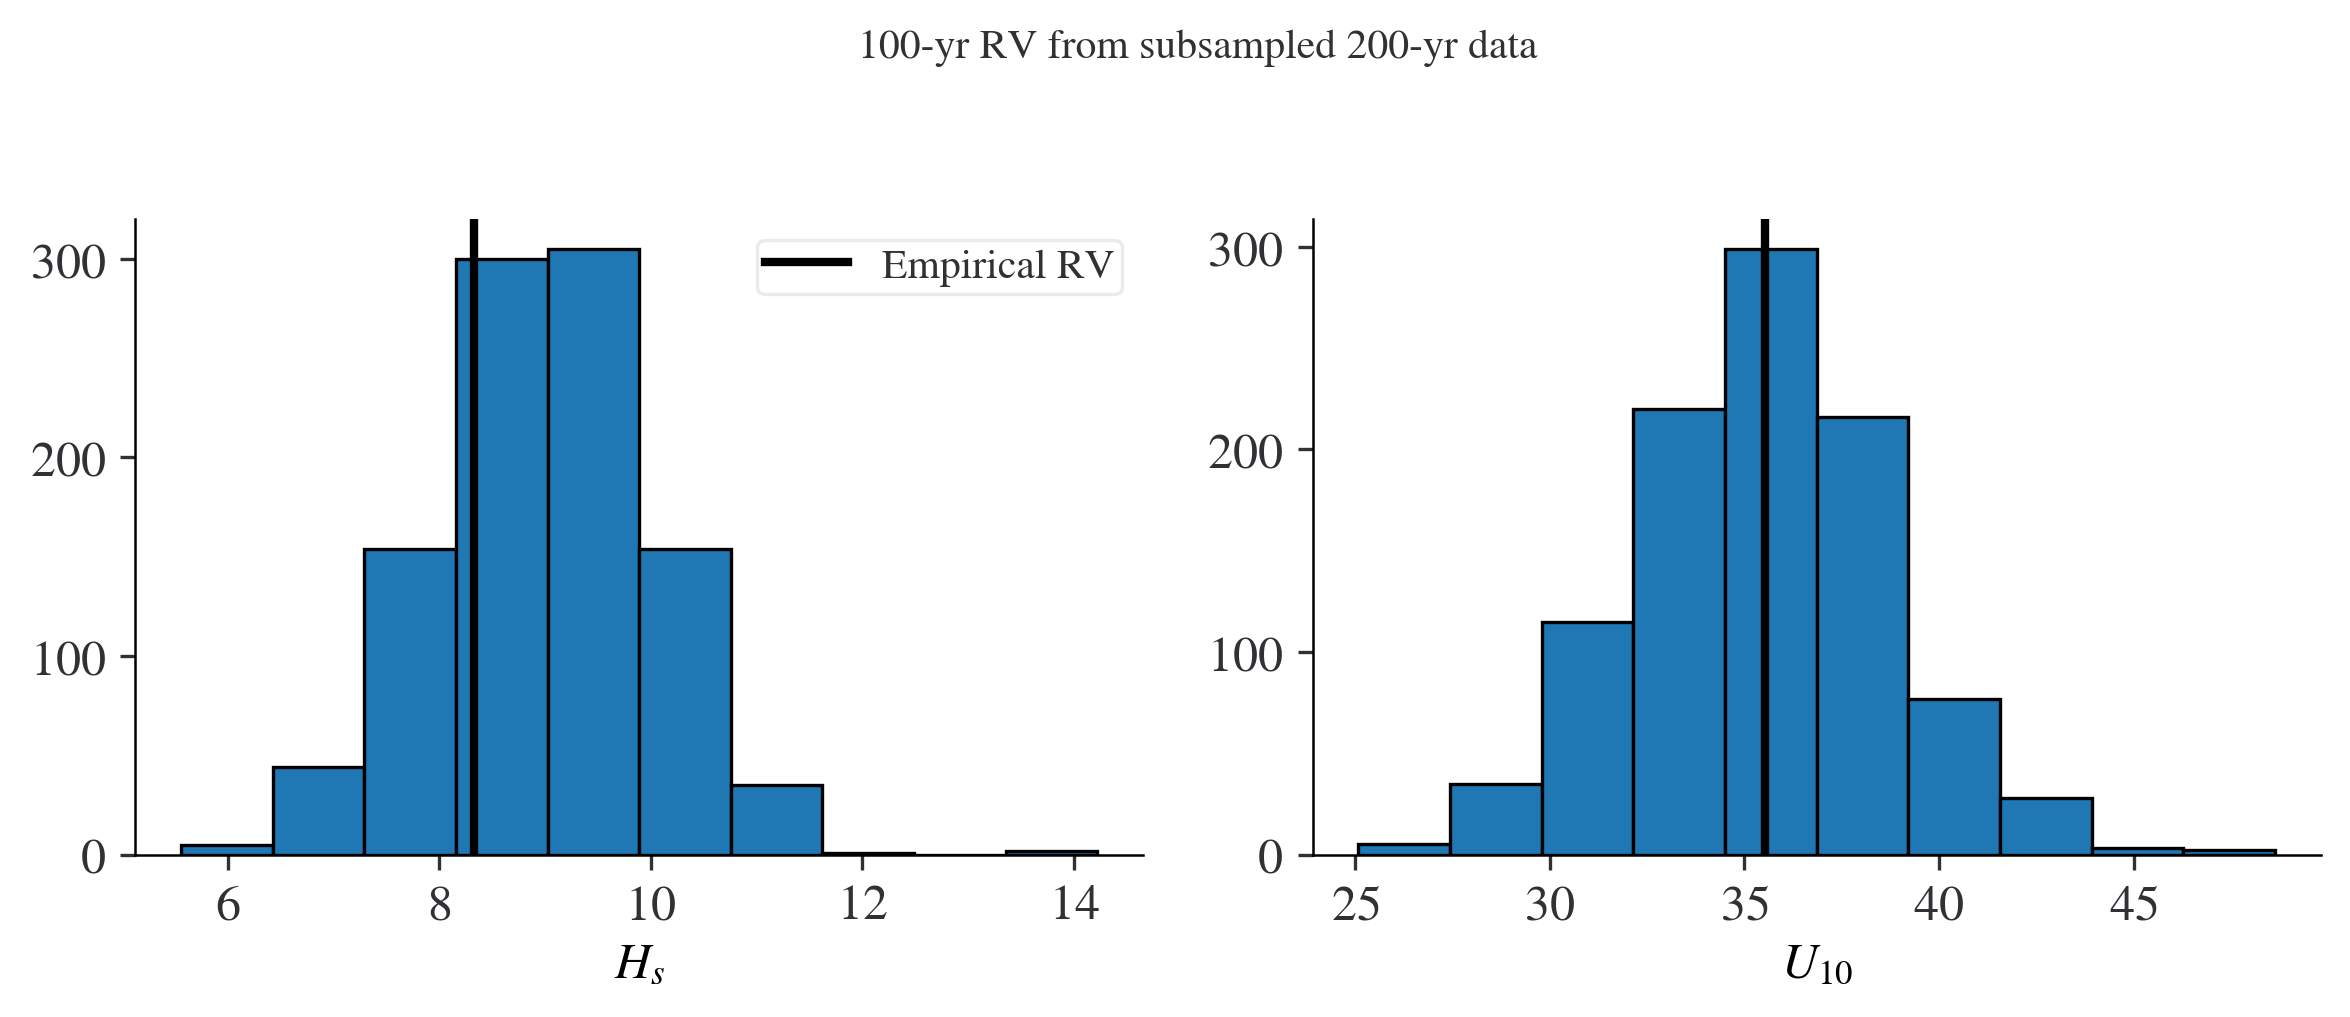

In [11]:
i = 30
ni = pos_list[i]
fig,ax= plt.subplots(1,2,figsize=(4*2,3))
fig.suptitle(f"{return_period}-yr RV from subsampled {N_year_pool}-yr data",size=10,y=1.05)
fig.tight_layout()
for S in STM:
  vi = S.idx()
  rv=[]
  for ssi in range(N_subsample):
    # calculate 100-yr RV
    tm = tm_MSTME_ss[ssi,vi,:,i]
    rv.append(np.percentile(tm,(1-exceedance_prob)*100))
  ax[vi].hist(rv)
  ax[vi].axvline(np.percentile(mstme_condition.tm[vi,:,ni],(1-exceedance_prob_original)*100),c='k')
  ax[vi].set_xlabel(S.name())
ax[0].legend([Line2D([0],[0],lw=2,color='k')],['Empirical RV'])
plt.savefig(dir_out/rf/f"example_empirical_vs_mstme.png", bbox_inches="tight")
plt.savefig(dir_out/rf/f"example_empirical_vs_mstme.pdf", bbox_inches="tight")

The empirical RV for $H_s$ is between 4.2% and 64.6% of the subsampled RV distribution
The empirical RV for $U_{10}$ is between 4.6% and 66.0% of the subsampled RV distribution


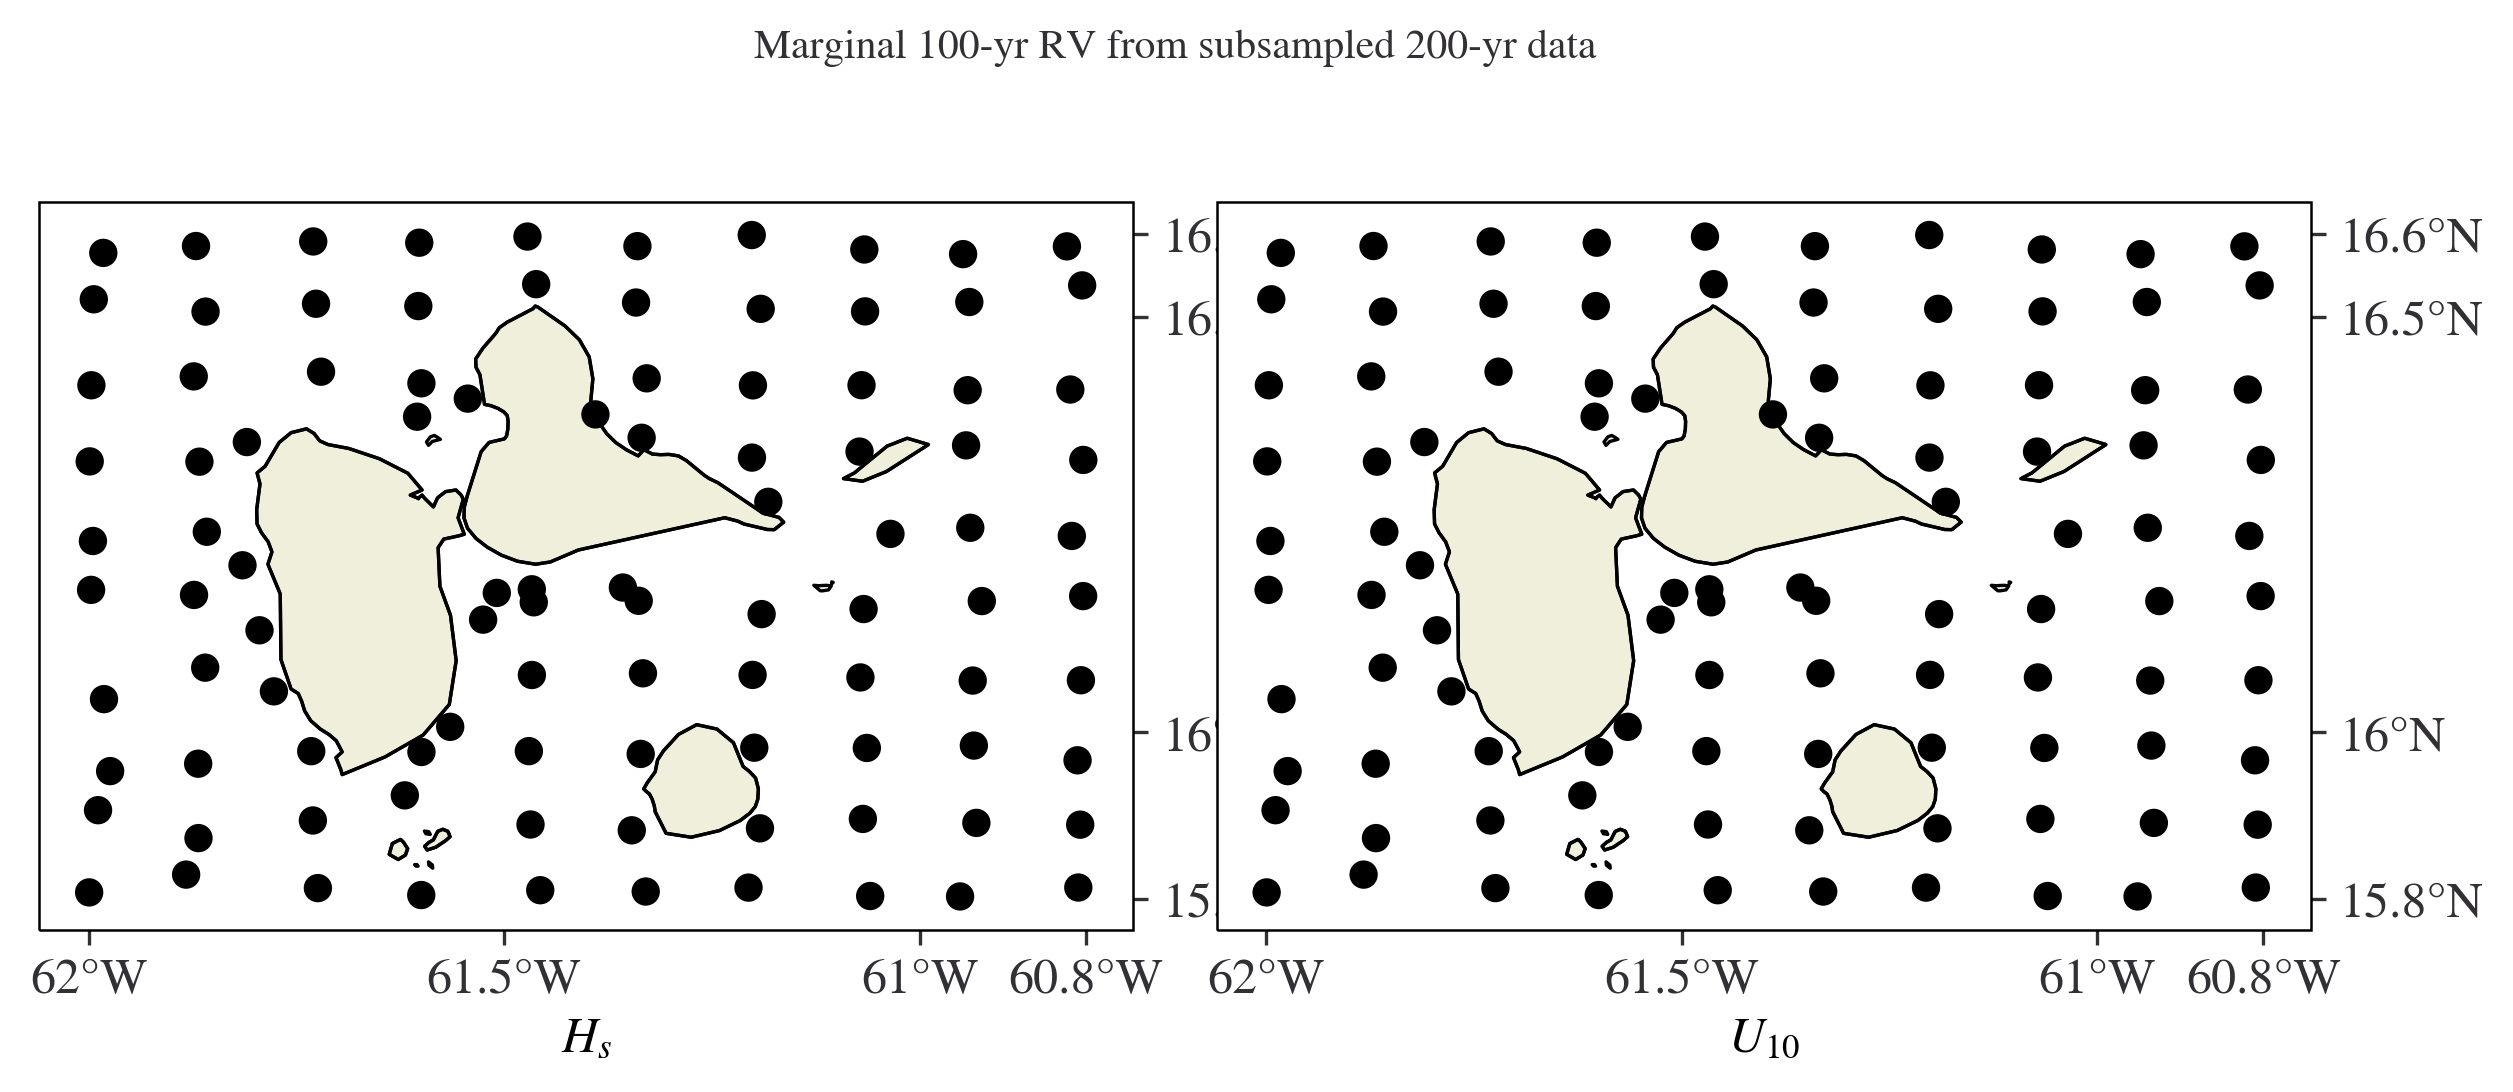

In [12]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(4 * 2, 3),
    subplot_kw={"projection": ccrs.PlateCarree()},
)
alpha=0.05
fig.suptitle(
    f"Marginal {return_period}-yr RV from subsampled {N_year_pool}-yr data", size=10, y=1.05
)
fig.tight_layout()
for S in STM:
    vi = S.idx()
    ax[vi] = grapher.custom_map(ax[vi], mstme_condition.area)
    pctile = []
    # for ni in range(mstme_condition.num_nodes):
    for i,ni in enumerate(pos_list):
        rv = []
        for ssi in range(N_subsample):
            # print(f"{vi}\t{i}\t{ssi}")
            # calculate 100-yr RV
            tm = tm_MSTME_ss[ssi, vi, :, i]
            rv.append(np.percentile(tm, (1 - exceedance_prob) * 100))
        rv_original = np.percentile(
            mstme_condition.tm[vi, :, ni], (1 - exceedance_prob_original) * 100
        )
        pctile.append(ECDF(rv)(rv_original))
        del rv_original
    ax[vi].scatter(
        # mstme_condition.latlon[:, 1],
        # mstme_condition.latlon[:, 0],
        mstme_condition.latlon[pos_list, 1],
        mstme_condition.latlon[pos_list, 0],
        c=['k' if 0.5-abs(p-0.5)>alpha/2 else 'red' for p in pctile],
        vmin=0,
        vmax=1,
        cmap="seismic",
    )
    print(f"The empirical RV for {S.name()} is between {min(pctile)*100:.1f}% and {max(pctile)*100:.1f}% of the subsampled RV distribution")
    ax[vi].set_xlabel(S.name())

IndexError: index 135 is out of bounds for axis 3 with size 100

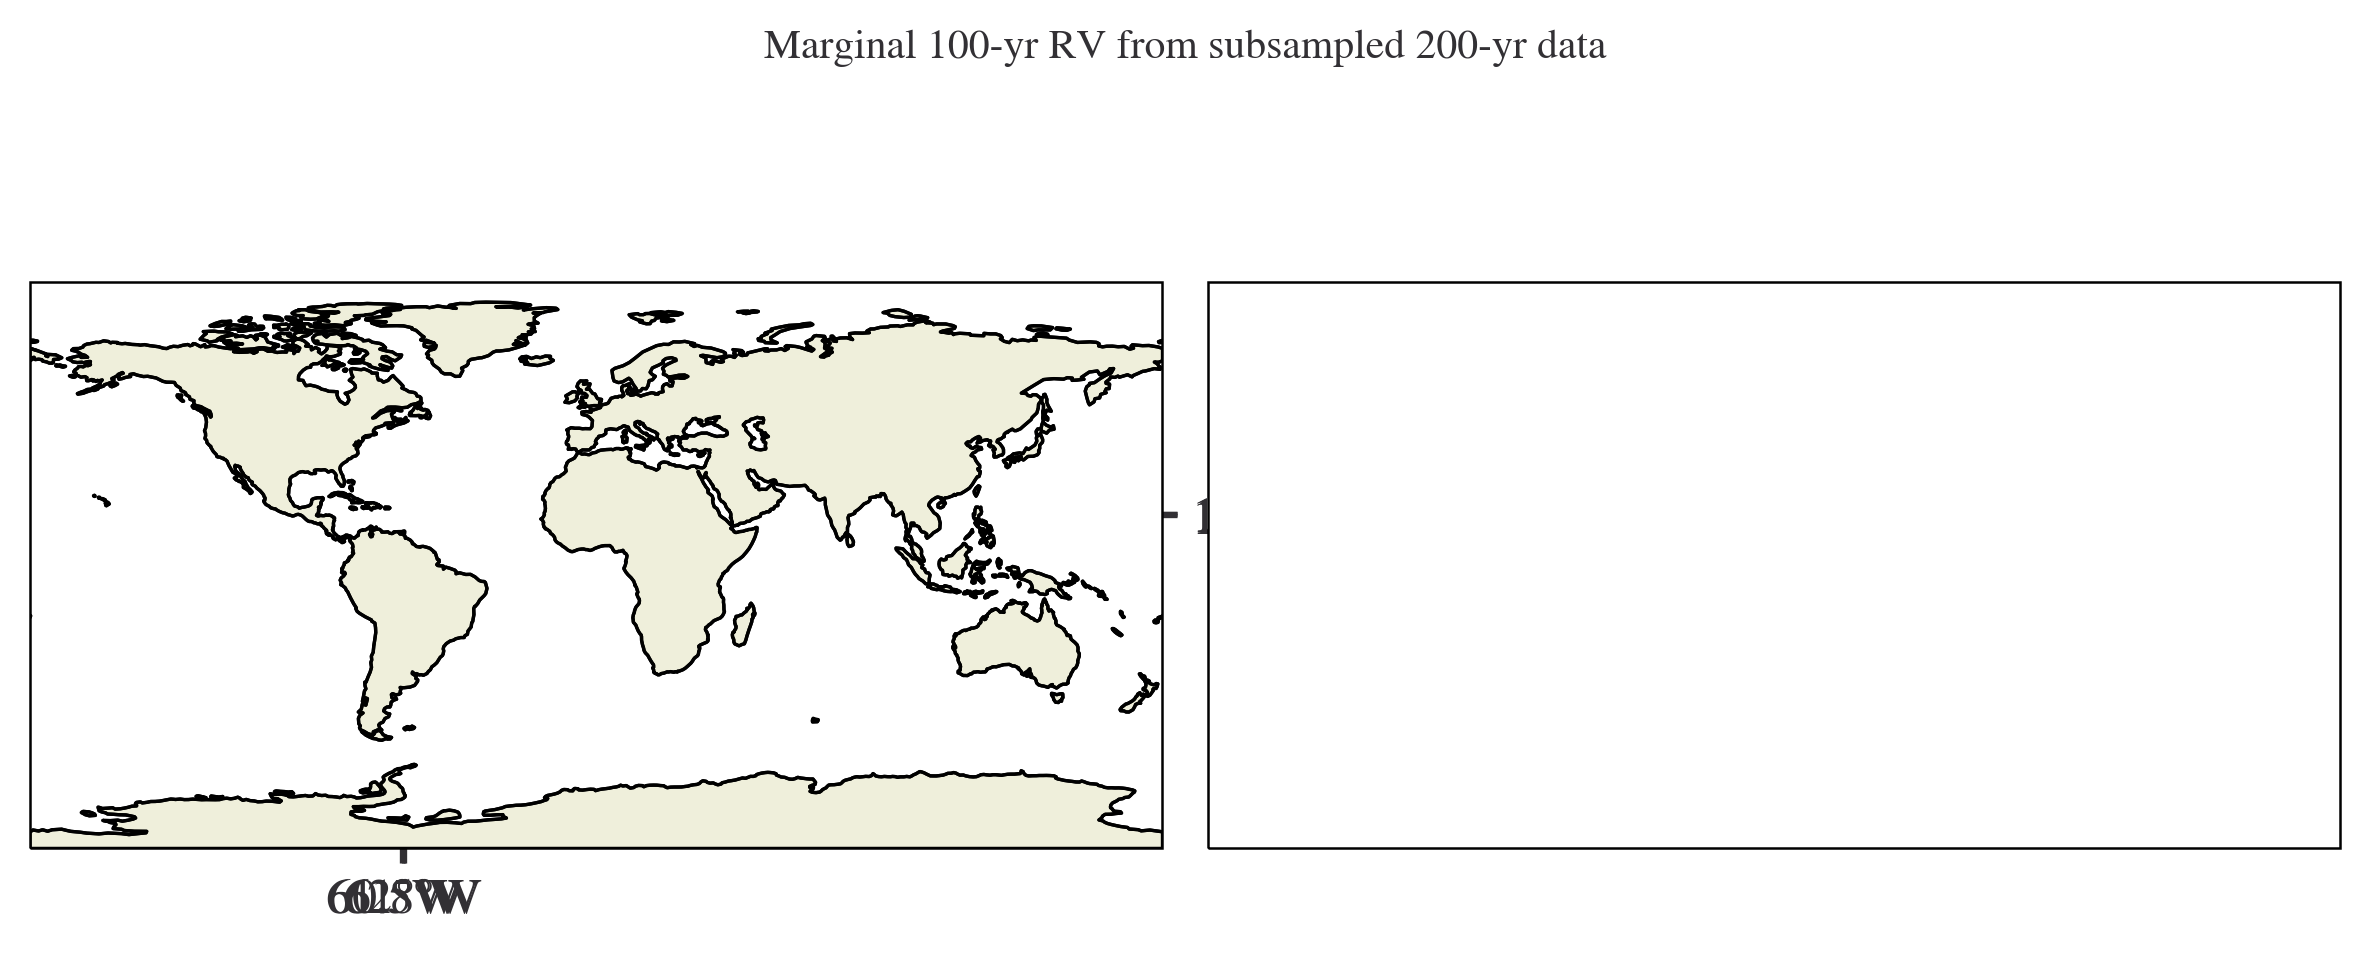

In [13]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(4 * 2, 3),
    subplot_kw={"projection": ccrs.PlateCarree()},
)
fig.suptitle(
    f"Marginal {return_period}-yr RV from subsampled {N_year_pool}-yr data", size=10, y=1.05
)
fig.tight_layout()
for S in STM:
    vi = S.idx()
    ax[vi] = grapher.custom_map(ax[vi], mstme_condition.area)
    rv_original_all = []
    for ni in pos_list:
        rv = []
        for ssi in range(N_subsample):
            # calculate 100-yr RV
            tm = tm_MSTME_ss[ssi, vi, :, ni]
            rv.append(np.percentile(tm, (1 - exceedance_prob) * 100))
        rv_original = np.percentile(
            mstme_condition.tm[vi, :, ni], (1 - exceedance_prob_original) * 100
        )
        rv_original_all.append(rv_original)
    im = ax[vi].scatter(
        mstme_condition.latlon[pos_list, 1],
        mstme_condition.latlon[pos_list, 0],
        c=rv_original_all,
        # vmin=0,
        # vmax=1,
        # cmap="seismic",
    )
    ax[vi].set_xlabel(S.name())
    plt.colorbar(im,ax=ax[vi],location='top',shrink=0.75)

_idx_cluster_mask.size: 477


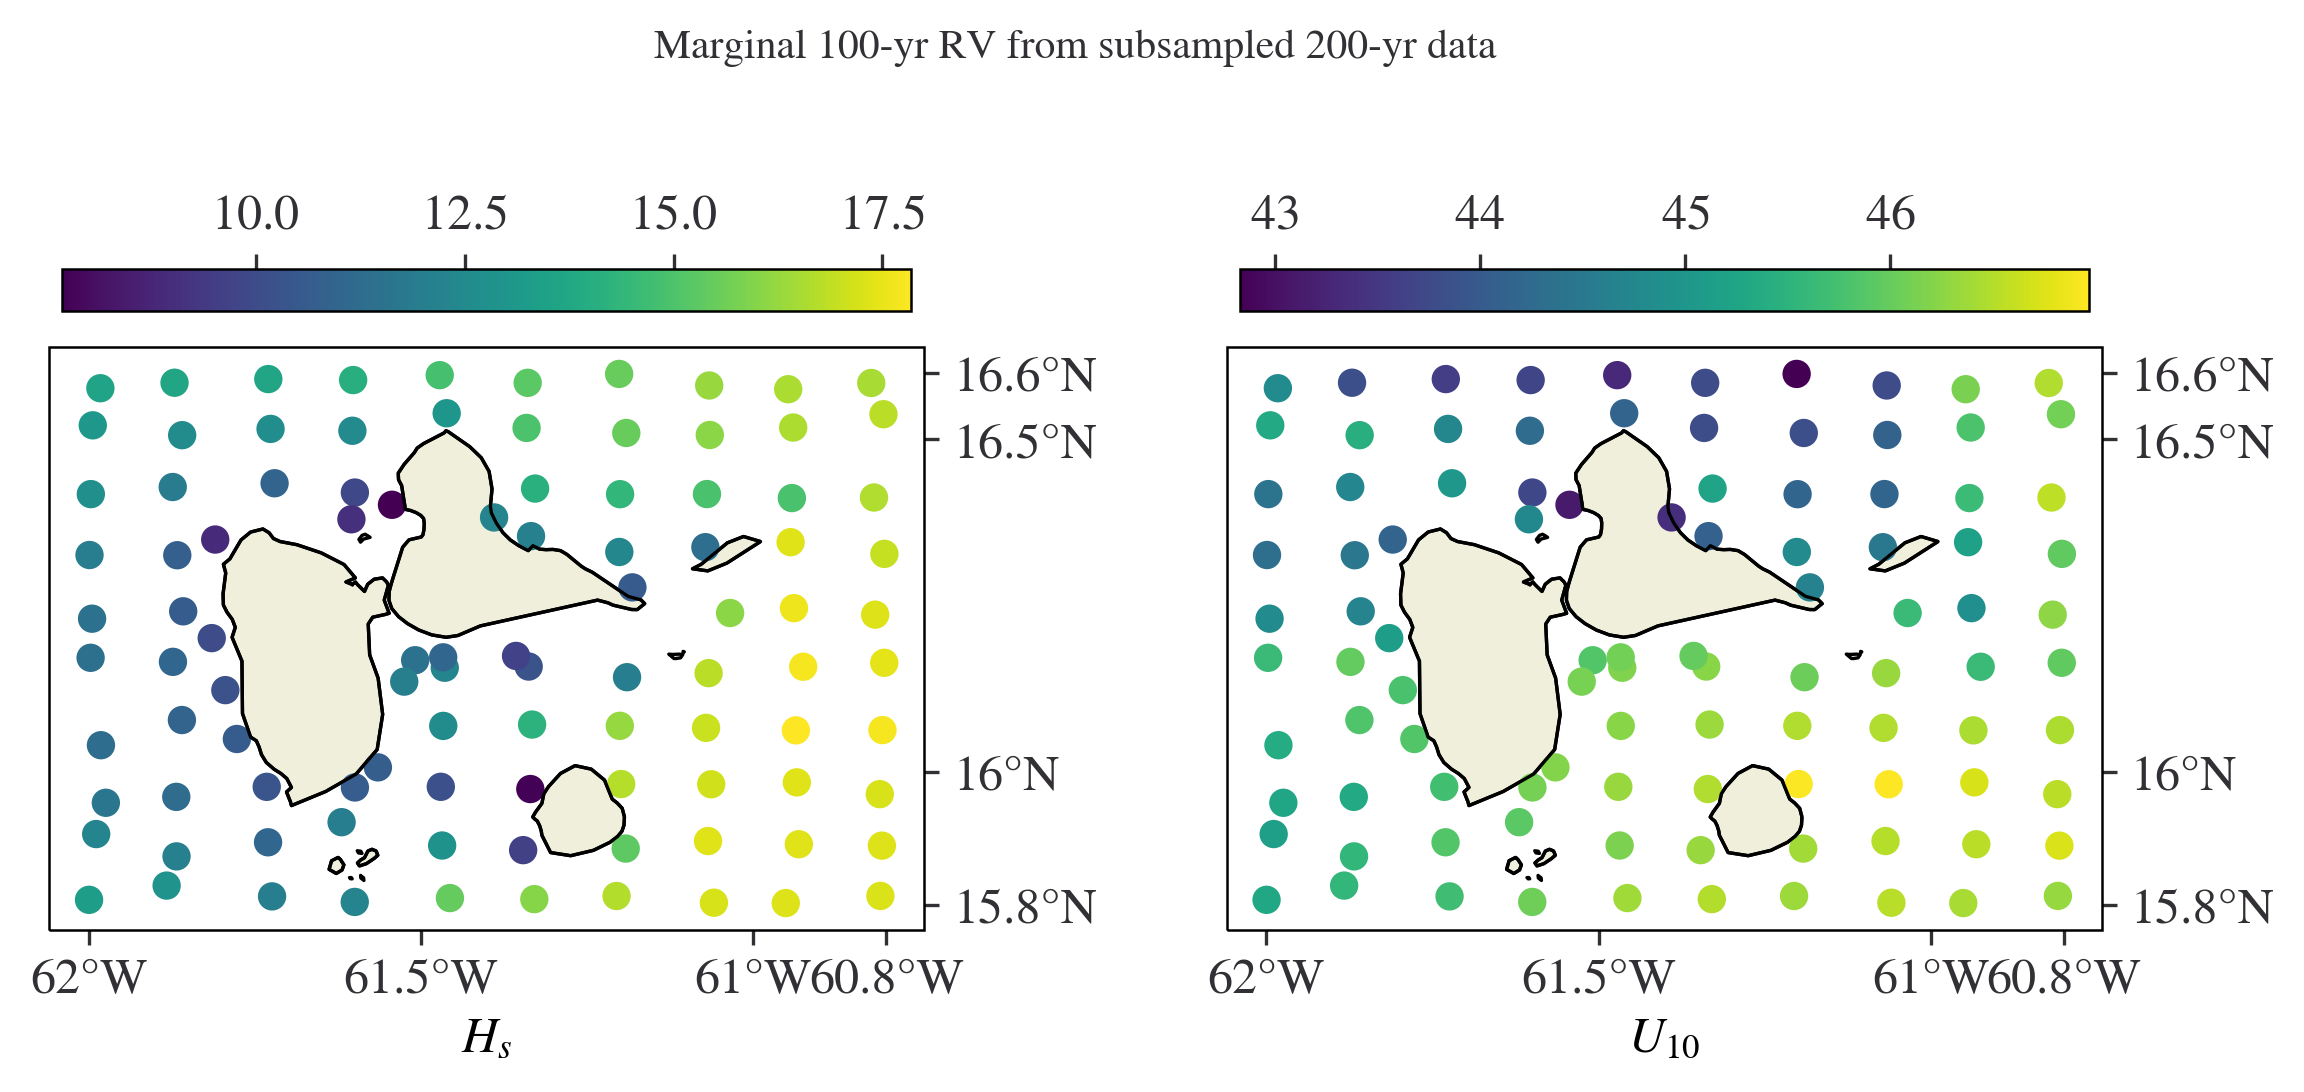

In [ ]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(4 * 2, 3),
    subplot_kw={"projection": ccrs.PlateCarree()},
)
fig.suptitle(
    f"Marginal {return_period}-yr RV from subsampled {N_year_pool}-yr data", size=10, y=1.05
)
fig.tight_layout()

_num_events_ss = round(N_year_pool * mstme_condition.occur_freq)
_mask_ss = mc._get_ss_pool(mstme_condition, 1, _num_events_ss)
_idx_mask = np.flatnonzero(_mask_ss)

for S in STM:
    vi = S.idx()
    ax[vi] = grapher.custom_map(ax[vi], mstme_condition.area)
    rv_original_all = []
    for ni in pos_list:
        rv = []
        for ssi in range(N_subsample):
            # calculate 100-yr RV
            tm = tm_MSTME_ss[ssi, vi, :, ni]
            rv.append(np.percentile(tm, (1 - exceedance_prob) * 100))
        rv_original = np.percentile(
            mstme_condition.tm[vi, :, ni], (1 - exceedance_prob_original) * 100
        )
        rv_original_all.append(rv_original)
    im = ax[vi].scatter(
        mstme_condition.latlon[pos_list, 1],
        mstme_condition.latlon[pos_list, 0],
        c=rv_original_all,
    )
    ax[vi].set_xlabel(S.name())
    plt.colorbar(im,ax=ax[vi],location='top',shrink=0.75)

In [ ]:
np.count_nonzero(_mask_ss)

120

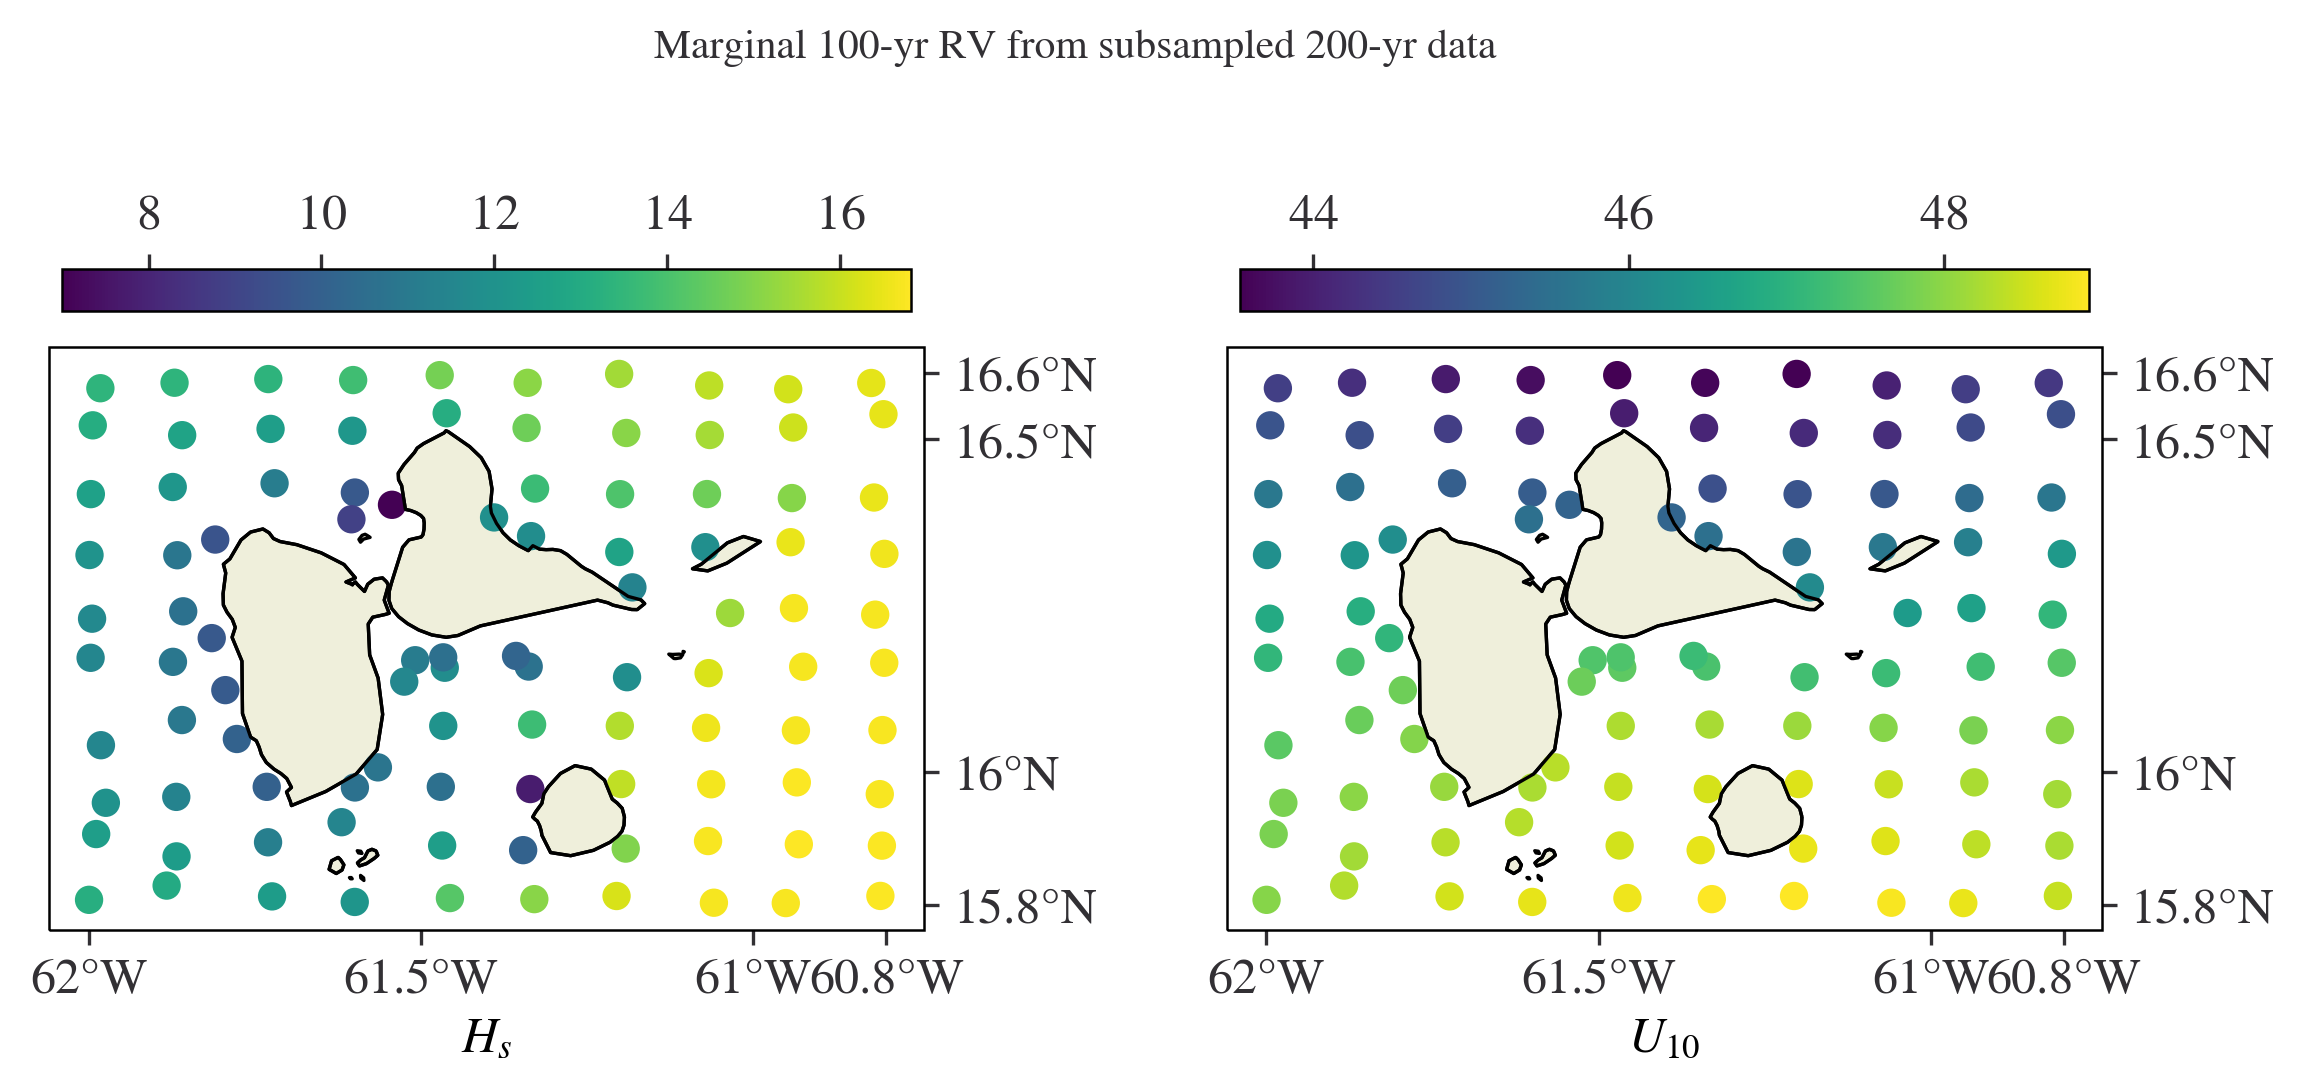

In [ ]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(4 * 2, 3),
    subplot_kw={"projection": ccrs.PlateCarree()},
)
fig.suptitle(
    f"Marginal {return_period}-yr RV from subsampled {N_year_pool}-yr data", size=10, y=1.05
)
fig.tight_layout()
for S in STM:
    vi = S.idx()
    ax[vi] = grapher.custom_map(ax[vi], mstme_condition.area)
    rv_all = []
    for ni in pos_list:
        rv = []
        for ssi in range(N_subsample):
            # calculate 100-yr RV
            tm = tm_MSTME_ss[ssi, vi, :, ni]
            rv.append(np.percentile(tm, (1 - exceedance_prob) * 100))
        rv_all.append(np.mean(rv))
    im = ax[vi].scatter(
        mstme_condition.latlon[pos_list, 1],
        mstme_condition.latlon[pos_list, 0],
        c=rv_all,
        # vmin=0,
        # vmax=1,
        # cmap="seismic",
    )
    ax[vi].set_xlabel(S.name())
    plt.colorbar(im,ax=ax[vi],location='top',shrink=0.75)

# PWE

In [11]:
tree_pwe = KDTree(mstme_condition.latlon[pos_list, :])
_, idx_list_pwe = tree_pwe.query(
    [
        [16.5,-61.8],
        [16.0,-61.9],
        [16.05,-61.4],
        [16.0,-61.0],
        [16.5,-61.1],
    ]
)
idx_list_pwe = idx_list_pwe.flatten()
idx_list_pwe = np.unique(idx_list_pwe)
pos_list_pwe = pos_list[idx_list_pwe]

In [12]:
path_tm_PWE_ss = (
    path_mstme.parent
    / f"tm_PWE_and_poslist_ss{N_subsample}_pool{N_year_pool}_{len(pos_list)}locations_3011.dill"
)
if path_tm_PWE_ss.exists():
    with open(path_tm_PWE_ss, "rb") as f:
        (tm_PWE_ss, pos_list_pwe) = dill.load(f)
else:
    tm_PWE_ss = mc._subsample_PWE(
        mstme_condition,
        N_subsample,
        N_year_pool,
        pos_list=pos_list_pwe,
        thr_pct_com=0.6,
    )
    with open(path_tm_PWE_ss, "wb") as f:
        dill.dump((tm_PWE_ss, pos_list_pwe), f)

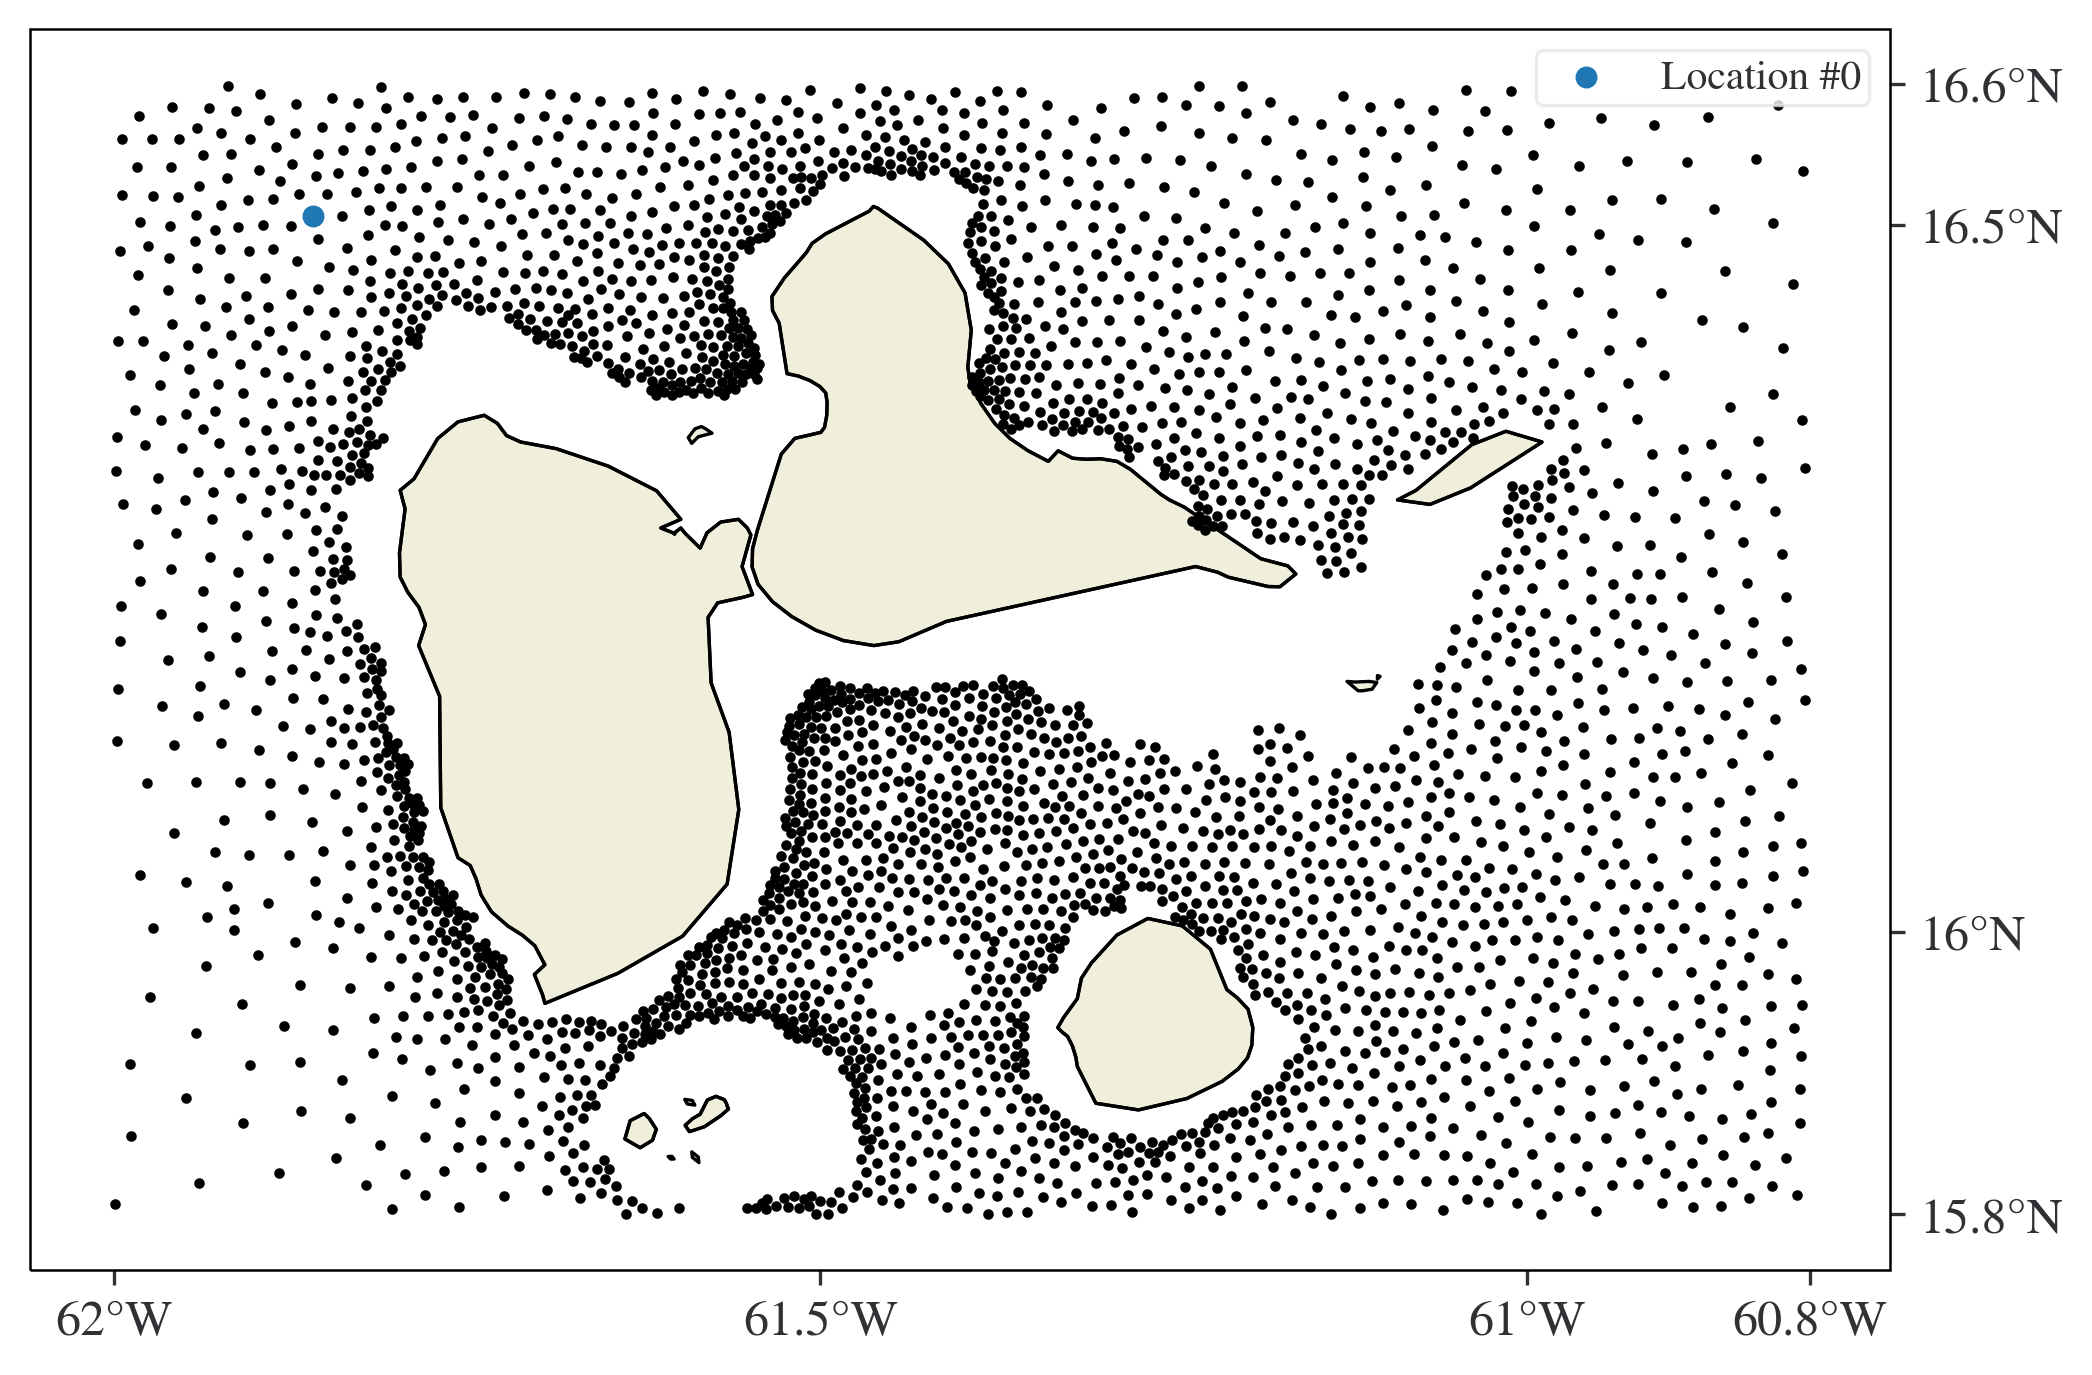

In [13]:
grapher.Grapher(mstme_condition).draw("General_Map",pos_list=pos_list_pwe,draw_fig=True,dir_out=None)


In [14]:
return_period=300


0
1


IndexError: index 1 is out of bounds for axis 2 with size 1

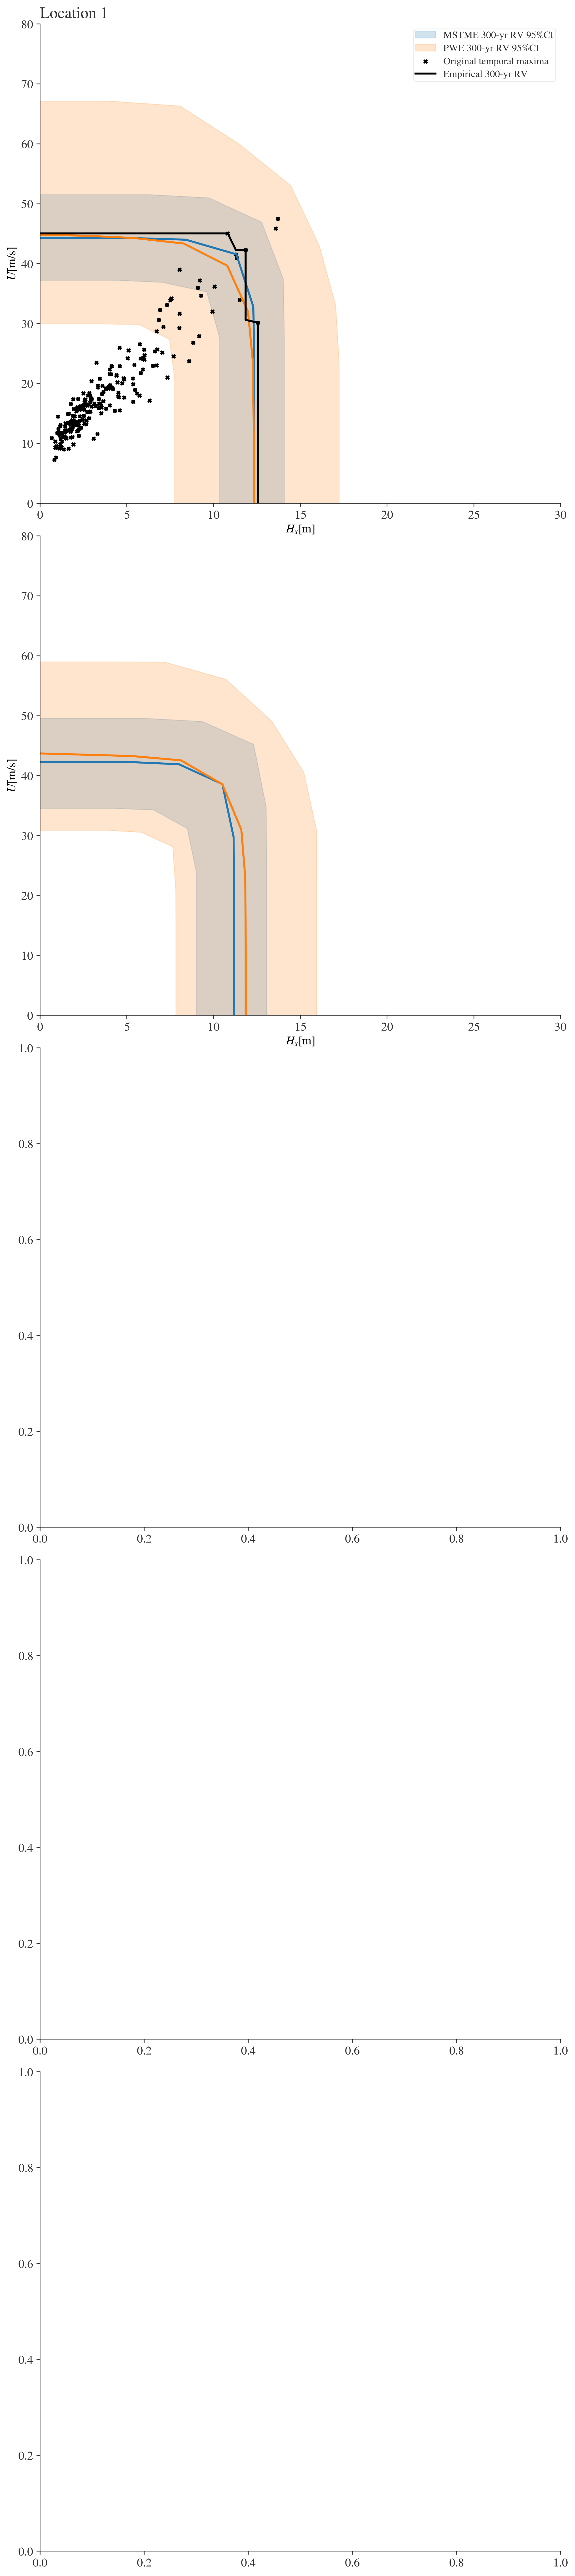

In [15]:
stm_min = [0, 0]
stm_max = [30, 80]
tm_original = mstme_condition.tm[:, :, pos_list_pwe]
tm_MSTME_ss_pwe = tm_MSTME_ss[:,:,:,idx_list_pwe]

# bi, ni, vi, ei
assert tm_MSTME_ss_pwe.shape == tm_PWE_ss.shape
N_subsample = tm_MSTME_ss_pwe.shape[0]
#########################################################
fig, axes = plt.subplots(
    5,
    1,
    figsize=(8, 6 *5*1.2),
    facecolor="white",
)
fig.tight_layout()
for i, ax in enumerate(axes.flatten()):
    print(i)
    ax.set_xlabel(r"$H_s$[m]")
    ax.set_ylabel(r"$U$[m/s]")
    ax.set_xlim(stm_min[0], stm_max[0])
    ax.set_ylim(stm_min[1], stm_max[1])
    # Sample count over threshold
    _num_events_sample = tm_MSTME_ss_pwe.shape[2]
    _exceedance_prob = 1 - mstme_condition.thr_pct_com
    _count_sample = round(
        _num_events_sample
        / (return_period * mstme_condition.occur_freq * _exceedance_prob)
    )
    _ic_original = []
    _num_events_original = tm_original.shape[1]
    _count_original = round(
        _num_events_original / (return_period * mstme_condition.occur_freq)
    )
    exceedance_prob_com_PWE = 1 - 0.7
    exceedance_prob = 1 / (return_period * mstme_condition.occur_freq * exceedance_prob_com_PWE)
    _count_sample_PWE = round(
        _num_events_sample
        / (return_period * mstme_condition.occur_freq * exceedance_prob_com_PWE)
    )
    # Bootstraps
    ic_MSTME = grapher._search_isocontours(tm_MSTME_ss_pwe[:, :, :, i], _count_sample)
    ic_PWE = grapher._search_isocontours(tm_PWE_ss[:, :, :, i], _count_sample_PWE)
    (
        ic_band_MSTME_u,
        ic_band_MSTME_l,
        ic_band_MSTME_m,
    ) = grapher._get_interp_band(
        ic_MSTME, scale=stm_max[1] / stm_max[0]
    )
    ic_band_PWE_u, ic_band_PWE_l, ic_band_PWE_m = grapher._get_interp_band(
        ic_PWE, scale=stm_max[1] / stm_max[0]
    )

    _fill_MSTME = np.concatenate(
        (ic_band_MSTME_u, np.flip(ic_band_MSTME_l, axis=1)), axis=1
    )
    _fill_PWE = np.concatenate(
        (ic_band_PWE_u, np.flip(ic_band_PWE_l, axis=1)), axis=1
    )
    ax.fill(
        _fill_MSTME[0],
        _fill_MSTME[1],
        alpha=0.2,
        c=pos_color[0],
        label=f"MSTME {return_period}-yr RV 95%CI",
    )
    ax.plot(
        ic_band_MSTME_m[0],
        ic_band_MSTME_m[1],
        c=pos_color[0],
        lw=2,
        # label=f"Empirical {return_period}-yr RV",
    )
    ax.fill(
        _fill_PWE[0],
        _fill_PWE[1],
        alpha=0.2,
        c=pos_color[1],
        label=f"PWE {return_period}-yr RV 95%CI",
    )

    ax.plot(
        ic_band_PWE_m[0],
        ic_band_PWE_m[1],
        c=pos_color[1],
        lw=2,
        # label=f"Empirical {return_period}-yr RV",
    )
    # Original
    _ic_original = grapher._search_isocontour(
        tm_original[:, :, i], _count_original
    )

    ax.scatter(
        tm_original[0, :, i],
        tm_original[1, :, i],
        s=10,
        c="black",
        label=f"Original temporal maxima",
        marker="x",
    )
    ax.plot(
        _ic_original[0],
        _ic_original[1],
        c="black",
        lw=2,
        label=f"Empirical {return_period}-yr RV",
    )
    ax.set_title(f"Location {i+1}")
    if i == 0:
        ax.legend()

## Normalized

In [ ]:
stm_min = [0, 0]
stm_max = [30, 80]
tm_original = mstme_condition.tm[:, :, pos_list_pwe]
tm_MSTME_ss_pwe = tm_MSTME_ss[:, :, :, idx_list_pwe]

tm_MSTME_ss_norm = np.empty(tm_MSTME_ss_pwe.shape)  # (ss,v,e,n)
tm_PWE_ss_norm = np.empty(tm_PWE_ss.shape)  # (ss,v,e,n)
tm_original_norm = np.empty(tm_original.shape)  # (ss,v,e,n)
for S in STM:
    vi = S.idx()
    tm_MSTME_ss_norm[:, vi, :, :] = np.clip(
        mstme_condition.ndist.ppf(
            mstme_condition.mix_dist[vi].cdf(tm_MSTME_ss_pwe[:, vi, :, :])
        ),
        -10,
        10,
    )
    tm_PWE_ss_norm[:, vi, :, :] = np.clip(
        mstme_condition.ndist.ppf(
            mstme_condition.mix_dist[vi].cdf(tm_PWE_ss[:, vi, :, :])
        ),
        -10,
        10,
    )
    tm_original_norm[vi, :, :] = np.clip(
        mstme_condition.ndist.ppf(
            mstme_condition.mix_dist[vi].cdf(tm_original[vi, :, :])
        ),
        -10,
        10,
    )


# bi, ni, vi, ei
assert tm_MSTME_ss_pwe.shape == tm_PWE_ss.shape
N_subsample = tm_MSTME_ss_pwe.shape[0]
#########################################################

_num_events_sample = tm_MSTME_ss_norm.shape[2]
_exceedance_prob = 1 - mstme_condition.thr_pct_com
_count_sample = round(
    _num_events_sample
    / (return_period * mstme_condition.occur_freq * _exceedance_prob)
)
exceedance_prob_com_PWE = 1 - 0.7
exceedance_prob = 1 / (
    return_period * mstme_condition.occur_freq * exceedance_prob_com_PWE
)
_count_sample_PWE = round(
    _num_events_sample
    / (return_period * mstme_condition.occur_freq * exceedance_prob_com_PWE)
)
_ic_original = []
_num_events_original = tm_original.shape[1]
_count_original = round(
    _num_events_original / (return_period * mstme_condition.occur_freq)
)

l_array_MSTME = []
l_array_PWE = []
l_array_original = []
for i in range(len(pos_list_pwe)):
    print(i)
    # ax.set_xlabel(r"$H_s$[m]")
    # ax.set_ylabel(r"$U$[m/s]")
    # ax.set_xlim(stm_min[0], stm_max[0])
    # ax.set_ylim(stm_min[1], stm_max[1])
    # # Sample count over threshold
    # Bootstraps
    ic_MSTME = grapher._search_isocontours(tm_MSTME_ss_norm[:, :, :, i], _count_sample)
    ic_PWE = grapher._search_isocontours(tm_PWE_ss_norm[:, :, :, i], _count_sample_PWE)
    ic_original = grapher._search_isocontour(tm_original_norm[:, :, i], _count_original)
    l_array_MSTME.append(grapher._get_interp_band_diag(ic_MSTME, scale=1))
    l_array_PWE.append(grapher._get_interp_band_diag(ic_PWE, scale=1))
    l_array_original.append(grapher._get_interp_band_diag([ic_original], scale=1))
l_array_MSTME = np.array(l_array_MSTME)
l_array_PWE = np.array(l_array_PWE)
l_array_original = np.array(l_array_original)

0
1
2
3
4


In [ ]:
bias_MSTME = np.mean(l_array_MSTME - l_array_original, axis=1)
var_MSTME = np.var(l_array_MSTME, axis=1)
bias_PWE = np.mean(l_array_PWE - l_array_original, axis=1)
var_PWE = np.var(l_array_PWE, axis=1)

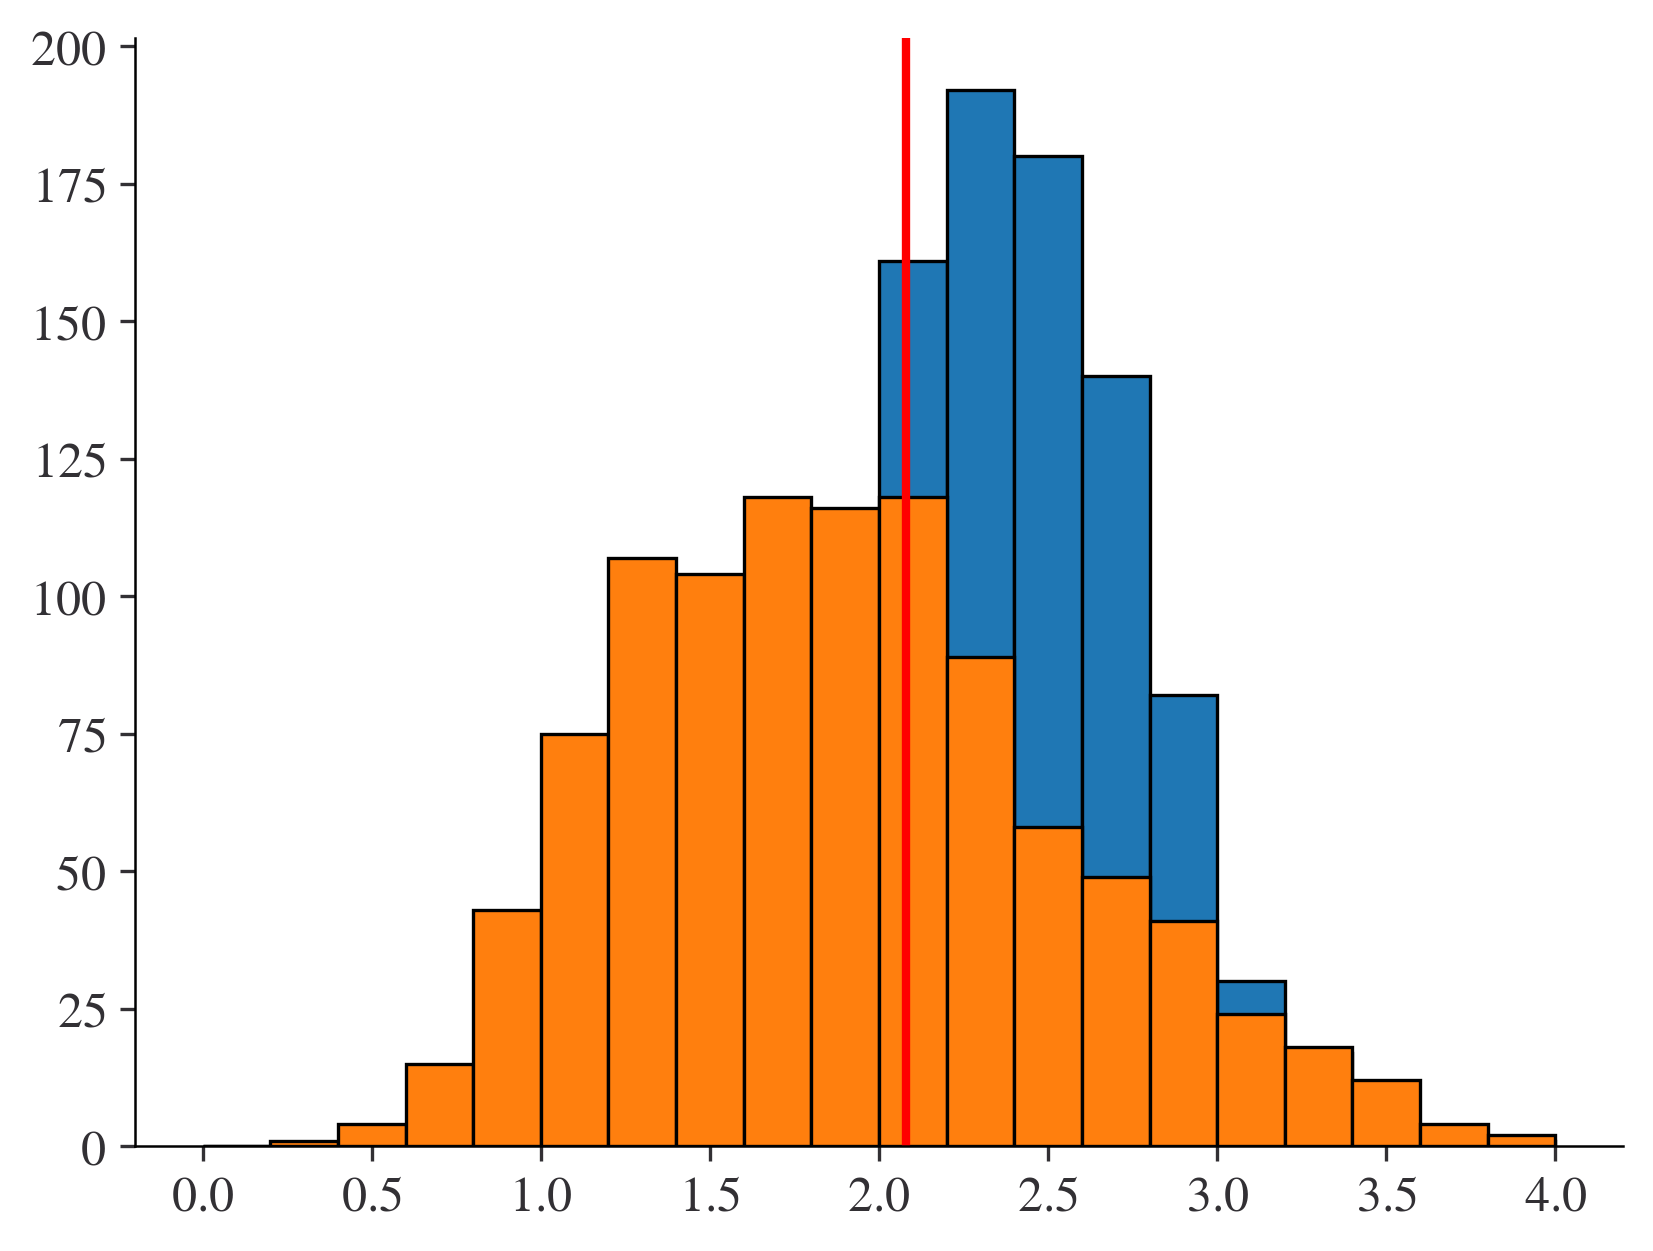

In [ ]:
bins = np.linspace(0,4,21)
plt.hist(l_array_MSTME[0],bins=bins)
plt.hist(l_array_PWE[0],bins=bins)
plt.axvline(l_array_original[0],c='r')

-0.5
0.5


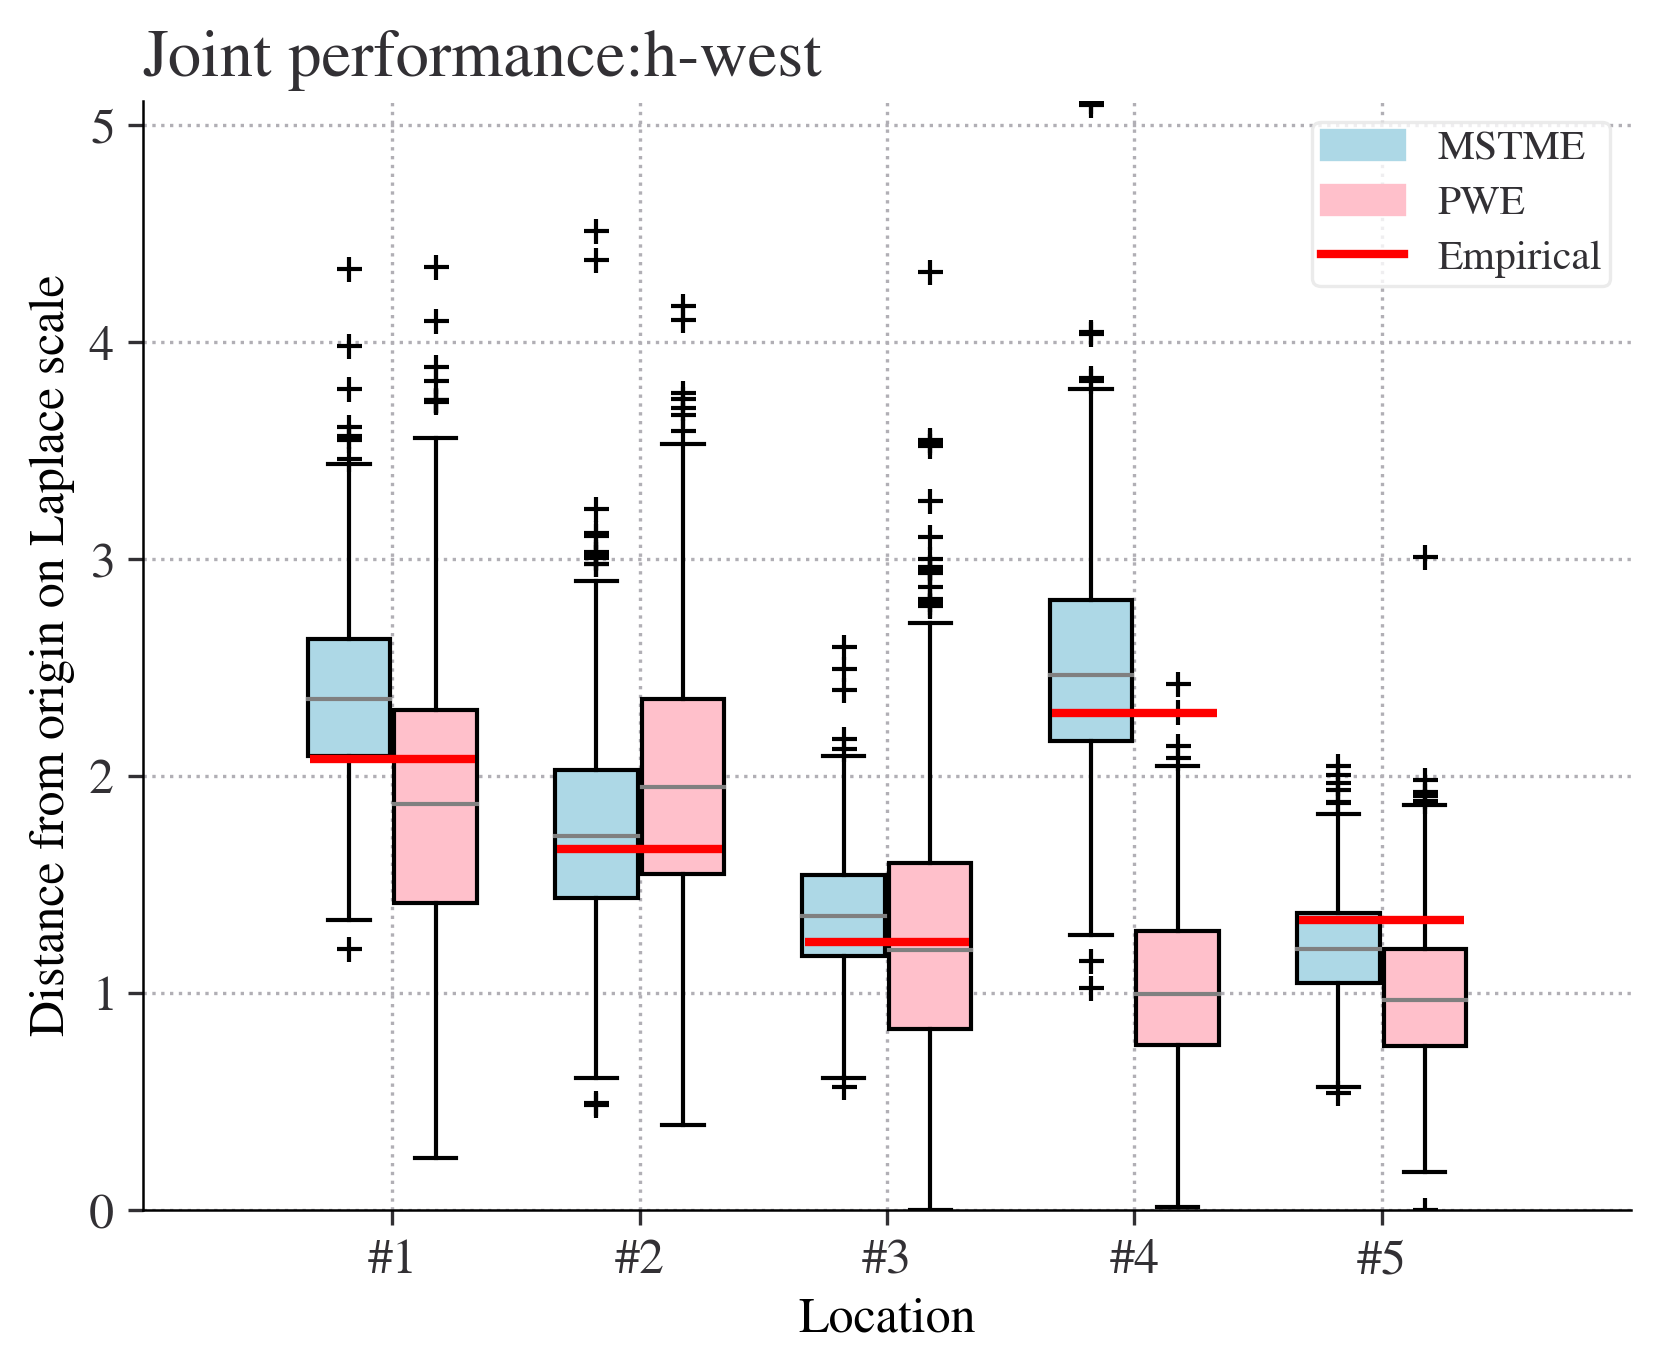

In [ ]:
# --- Combining your data:
data_group1 = l_array_MSTME.tolist()
data_group2 = l_array_PWE.tolist()

colors = ["lightblue", "pink"]

# we compare the performances of the 2 individuals within the same set of 5 settings
data_groups = [data_group1, data_group2]

# --- Labels for your data:
labels_list = [f"#{i}" for i in range(1, 1 + len(pos_list_pwe))]
width = 1 / len(labels_list)
xlocations = [x * ((1 + len(data_groups)) * width) for x in range(len(data_group1))]

symbol = "k+"
ymin = min([val for dg in data_groups for data in dg for val in data])
ymax = max([val for dg in data_groups for data in dg for val in data])

ax = plt.gca()
ax.set_ylim(ymin, ymax)

ax.grid(True, linestyle="dotted")
ax.set_axisbelow(True)

plt.xlabel("Location")
plt.ylabel("Distance from origin on Laplace scale")
plt.title(f"Joint performance:{rf}")

space = len(data_groups) / 2
offset = len(data_groups) / 2


# --- Offset the positions per group:

group_positions = []
for num, dg in enumerate(data_groups):
    _off = 0 - space + (0.5 + num)
    print(_off)
    group_positions.append([x + _off * (width + 0.01) for x in xlocations])


for dg, pos, c in zip(data_groups, group_positions, colors):
    boxes = ax.boxplot(
        dg,
        sym=symbol,
        labels=[""] * len(labels_list),
        #            labels=labels_list,
        positions=pos,
        widths=width,
        boxprops=dict(facecolor=c),
        #             capprops=dict(color=c),
        #            whiskerprops=dict(color=c),
        # flierprops=dict(color='k', markeredgecolor='k'),
        medianprops=dict(color="grey"),
        #           notch=False,
        #           vert=True,
        #           whis=1.5,
        #           bootstrap=None,
        #           usermedians=None,
        #           conf_intervals=None,
        patch_artist=True,
    )
ax.set_xticks(xlocations)
ax.set_xticklabels(labels_list, rotation=0)

for i in range(len(pos_list_pwe)):
    ax.hlines(
        l_array_original[i],
        xlocations[i] - width,
        xlocations[i] + width,
        color="r",
        lw=2,
        zorder=10,
    )

custom_lines = [
    mpatches.Patch(color="lightblue"),
    mpatches.Patch(color="pink"),
    Line2D([0], [0], color="r"),
]

# ax.legend(custom_lines, [f'{thr:.2f}'for thr in thr_com_list])
ax.legend(custom_lines, ["MSTME", "PWE", "Empirical"])

plt.show()

# Dump

In [ ]:
# with open(path_notebook,'wb') as f:
#     dill.dump_session(f)

In [18]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                   tm_MSTME_ss: 47.5 GiB
                  stm_MSTME_ss: 15.3 MiB
                            rv:  2.8 KiB
                          _i12:  1.4 KiB
                          _i13:  1.4 KiB
                            _i:  1.4 KiB
                           _ii:  1.4 KiB
                          _iii:  1.4 KiB
                          _i14:  1.4 KiB
                          _i15:  1.4 KiB
